In [1]:
# zstandard needs to be imported before graph_tool!!
import zstandard
import graph_tool.all as gt

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle

from pygenstability import plotting
from pygenstability.contrib.optimal_scales import *

# Setup MSF

In [3]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from msfiltration import MSF
from msfiltration.msf_bootstrapping import plot_pds, select_scales_pds, msf_bootstrap

In [4]:
# Set MS parameters
n_time = 200
min_time = -1.5
max_time = 0.5

In [5]:
# number of bootstraps
B = 20
# number of samples for each bootstrap
n_sample = 150

# 2nd real network: EU Airlines

https://networks.skewed.de/net/eu_airlines

In [6]:
# Load network with gt
G_gt = gt.collection.ns["eu_airlines"]

# Extract LCC
G_gt = gt.extract_largest_component(G_gt)

# Get sparse adjacency matrix
A = gt.adjacency(G_gt)

# Import graph to networkx
G = nx.from_scipy_sparse_matrix(A)

In [7]:
# Compute spring layout
pos = nx.spring_layout(G,seed=5)

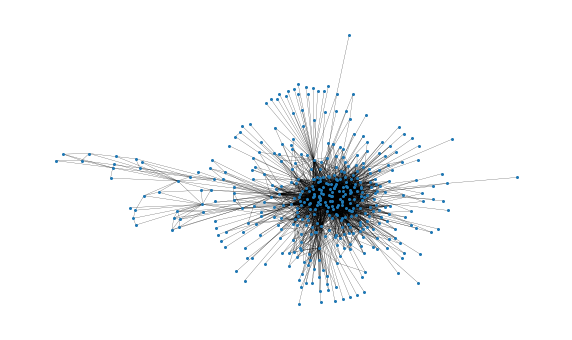

In [8]:
# Plot network
fig, ax = plt.subplots(1,figsize =(10,6))
nx.draw(G,ax=ax,pos=pos, node_size = 4,width = 0.2)

In [9]:
print(G)

Graph with 417 nodes and 2953 edges


### Full MSF

In [10]:
# # initialise MSF object
# msf = MSF()

# # run MS analysis, build filtration and compute PH
# msf.fit_transform(A,min_time,max_time,n_time,with_ttprime=True,with_optimal_scales=True)

In [11]:
root = "/home/tc/OneDrive/Software/MSFiltration/experiments/results/real networks/"

In [12]:
# # store ms results
# with open(root + "ms_eu_airlines.pkl", "wb") as handle:
#     pickle.dump(
#         msf.ms_results, handle, protocol=pickle.HIGHEST_PROTOCOL,
#     )

In [13]:
# load ms results
with open(root + "ms_eu_airlines.pkl", 'rb') as handle:
        ms_results = pickle.load(handle)

# initialise new MSF object and compute PH
msf = MSF()
msf.load_ms_results(ms_results)
msf.build_filtration()
msf.compute_persistence()

Building filtration ...


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


Computing persistence ... 


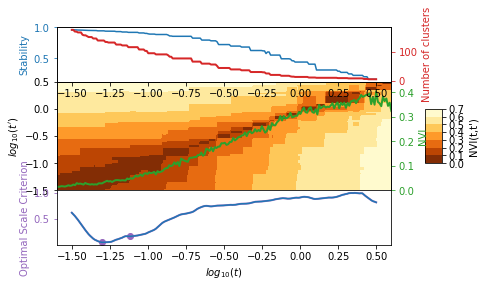

In [14]:
# select optimal scales with nvi
identify_optimal_scales(msf.ms_results,criterion_threshold=0,window_size=20)
selected_scales_nvi = msf.log_times[msf.ms_results['selected_partitions']]
# plot nvi summary of ms
plotting.plot_scan(msf.ms_results)

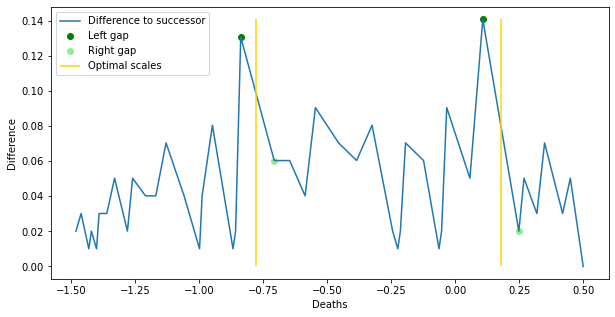

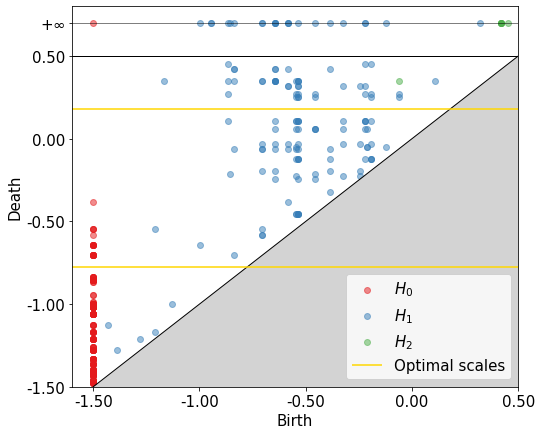

In [15]:
# select optimal scales with ph
msf.select_scales(with_plot=True, threshold_abs=0,min_gap_width=0.105)
# plot persistence diagram with optimal scales
ax = msf.plot_persistence_diagram()

### Bootstrap MSF

In [16]:
persistences_bootstrapped = msf_bootstrap(msf.community_ids, msf.log_times, n_sample, B)

Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 173.21it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:00<00:00, 205.79it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 195.40it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 172.04it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 154.35it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:00<00:00, 215.36it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 182.01it/s]


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 175.85it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 172.56it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 190.34it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 162.93it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:00<00:00, 252.42it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 161.70it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 151.94it/s]


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 176.77it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 192.69it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 124.29it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 116.29it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 167.72it/s] 


Computing persistence ... 
Building filtration ...


100%|██████████| 200/200 [00:01<00:00, 184.59it/s] 


Computing persistence ... 


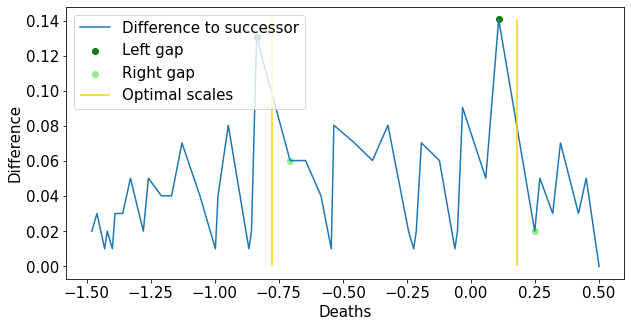

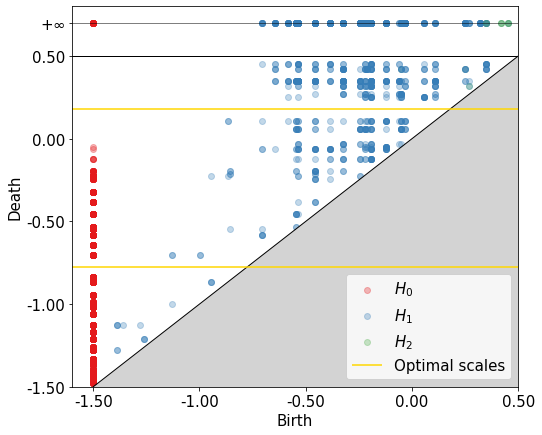

In [17]:
# select optimal scales with ph
optimal_scales_ph, gap_width, ax = select_scales_pds(persistences_bootstrapped, msf.log_times, with_plot=True,threshold_abs=0,min_gap_width=0.105)

# plot optimal scales in PD
fig, ax = plot_pds(persistences_bootstrapped,msf.log_times,optimal_scales_ph,alpha=0.3)

# Develop density based approach for scale selection

1. Get number of deaths per time (option to specify only certain homology groups)
2. Identify areas of low density
3. Select optimal scales as the left gaps of the low density area (these correspond to the partitions that resolve conflicts)

4. Integrate birth counts. A scale is bad if it has a high number of births.

In [18]:
dim = 1

In [19]:
n_times = len(msf.log_times)


In [79]:
def compute_death_count(dim):

    # get all deaths for dimension
    all_deaths = msf.filtration.persistence_intervals_in_dimension(dim)[:,1]

    # initialise death density array where the last entry corresponds to inf
    death_count = np.zeros(n_times+1)

    # count deaths for each scale
    for i in range(n_times):
        death_count[i] = np.sum(all_deaths == msf.log_times[i])
    
    # count inf
    death_count[n_time] = np.sum(all_deaths == np.Inf)

    return death_count

def compute_birth_count(dim):

    # get all births for dimension
    all_births = msf.filtration.persistence_intervals_in_dimension(dim)[:,0]

    # initialise death density array where the last entry corresponds to inf
    birth_count = np.zeros(n_times+1)

    # count deaths for each scale
    for i in range(n_times):
        birth_count[i] = np.sum(all_births == msf.log_times[i])
    
    # count inf
    birth_count[n_time] = np.sum(all_births == np.Inf)

    return birth_count

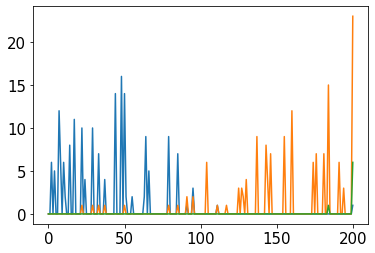

In [71]:
plt.plot(compute_death_count(0))
plt.plot(compute_death_count(1))
plt.plot(compute_death_count(2))

In [80]:
def compute_combined_death_density(dimensions):

    # initialise combined death density array where the last entry corresponds to inf
    combined_death_count = np.zeros(n_times+1)

    # sum of densities for different dimensions
    for dim in dimensions:

        combined_death_count += compute_death_count(dim)

    # normalise
    return combined_death_count/np.sum(combined_death_count), np.sum(combined_death_count)
    
def compute_combined_birth_density(dimensions):

    # initialise combined death density array where the last entry corresponds to inf
    combined_birth_count = np.zeros(n_times+1)

    # sum of densities for different dimensions
    for dim in dimensions:

        combined_birth_count += compute_birth_count(dim)

    # normalise
    return combined_birth_count/np.sum(combined_birth_count), np.sum(combined_birth_count)

In [103]:
death_density, death_total = compute_combined_death_density([0])
birth_density, birth_total = compute_combined_birth_density([0])

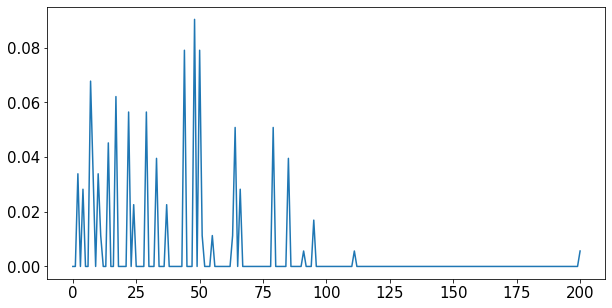

In [105]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(death_density)
#ax.plot(birth_density, ls = '--')
plt.show()

In [94]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [99]:
peaks, _ = find_peaks(death_density,height=2/death_total)

In [101]:
peaks

array([  2,   4,   7,  10,  14,  17,  22,  24,  29,  33,  37,  44,  48,
        50,  55,  64,  66,  79,  85,  91,  95, 104, 111, 125, 127, 130,
       137, 143, 146, 155, 160, 174, 176, 181, 184, 191, 194])

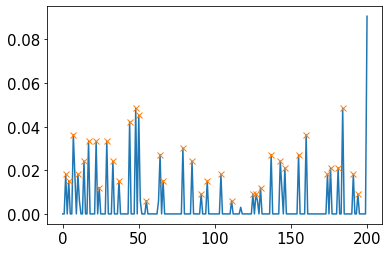

In [102]:
plt.plot(death_density)
plt.plot(peaks,death_density[peaks],'x')

In [199]:
widths = peak_widths(density[:-1], peaks, rel_height=1)

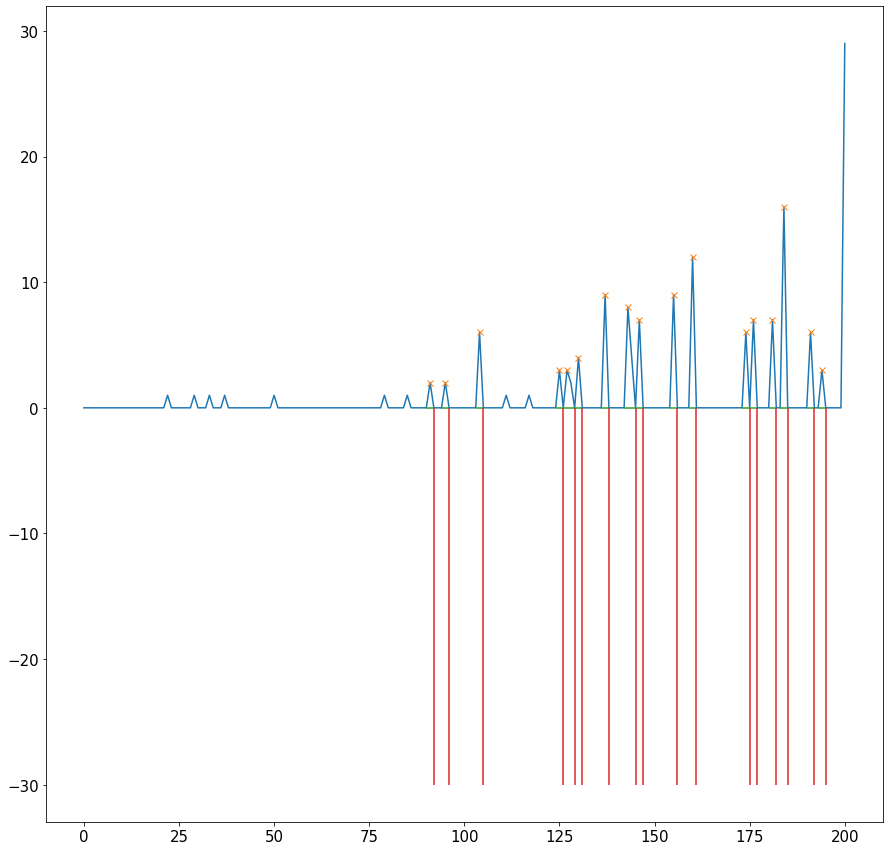

In [200]:
# create axis
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.plot(density)
ax.plot(peaks,density[peaks],'x')
ax.hlines(*widths[1:], color="C2")
ax.vlines(widths[3],ymin=-30,ymax=0, color="C3")

In [201]:
widths

(array([2., 2., 2., 2., 3., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 90.,  94., 103., 124., 126., 129., 136., 142., 145., 154., 159.,
        173., 175., 180., 183., 190., 193.]),
 array([ 92.,  96., 105., 126., 129., 131., 138., 145., 147., 156., 161.,
        175., 177., 182., 185., 192., 195.]))

In [202]:
prominences = peak_prominences(density, peaks)

In [203]:
contour_heights = density[peaks] - prominences[0]

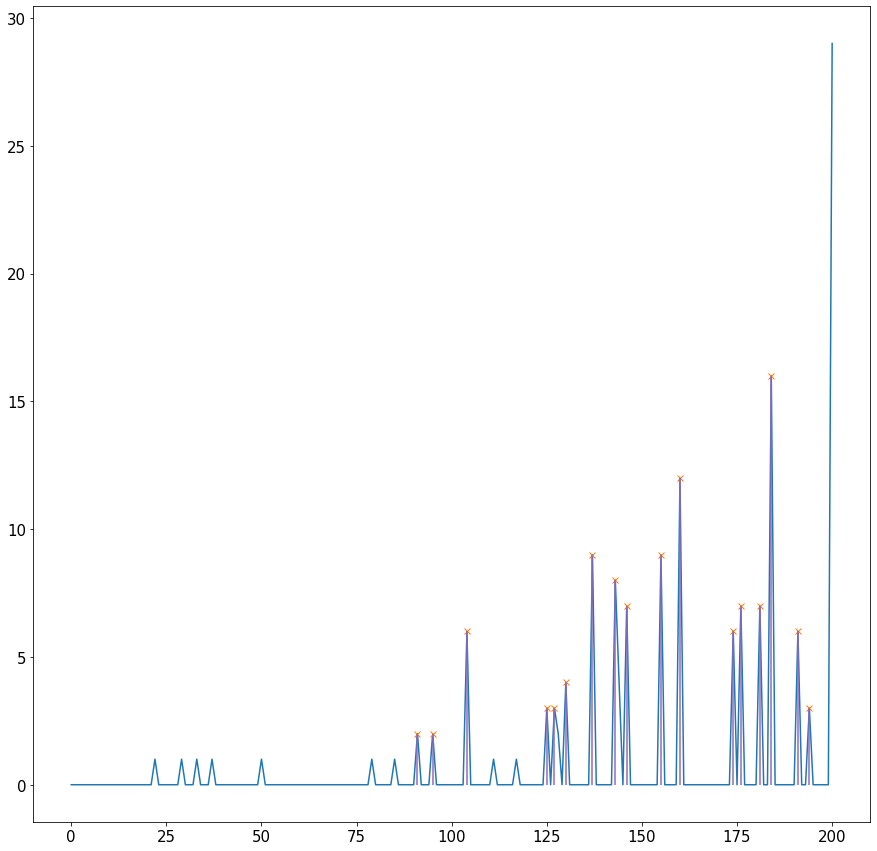

In [205]:
# create axis
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.plot(density)
ax.plot(peaks,density[peaks],'x')
plt.vlines(x=peaks, ymin=contour_heights, ymax=density[peaks],color="C4")

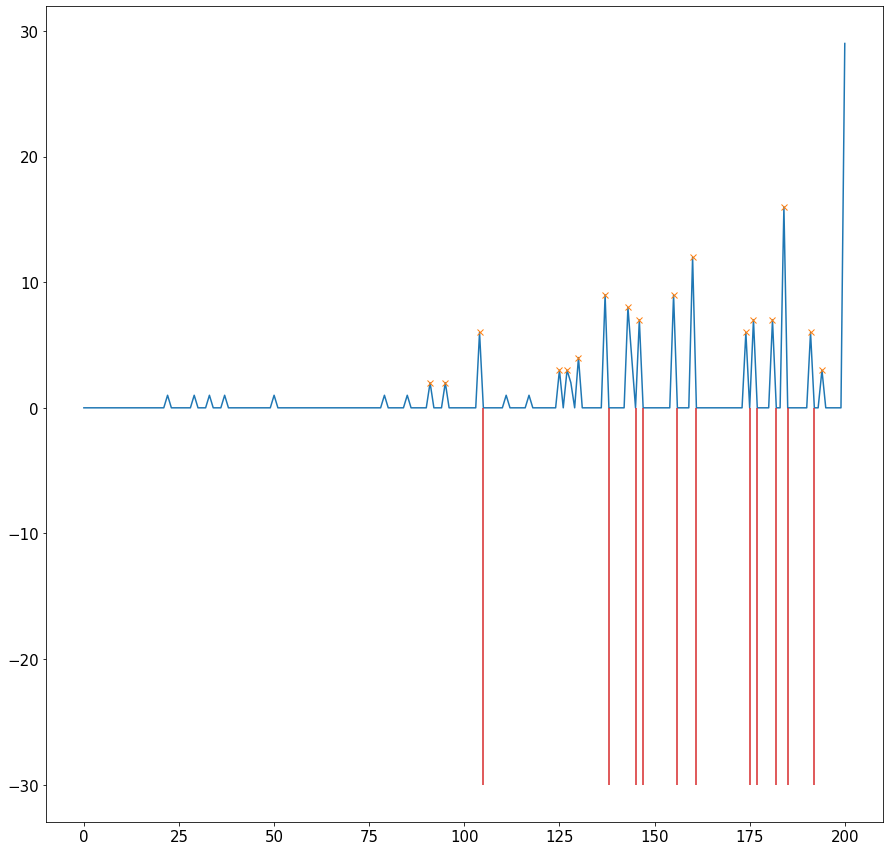

In [209]:
# create axis
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.plot(density)
ax.plot(peaks,density[peaks],'x')
ax.vlines(prominences[2][prominences[0]>5],ymin=-30,ymax=0, color="C3")

# Comparison of $\beta_0$ and rank(Partition)

In [127]:
# compute rank of partition matrix
rank = np.asarray([len(np.unique(msf.community_ids[i])) for i in range(len(msf.log_times))])
# compute beta_0
death_count_0 = compute_death_count(0)
beta_0 = np.sum(death_count_0)-np.cumsum(death_count_0) # CORRECT?

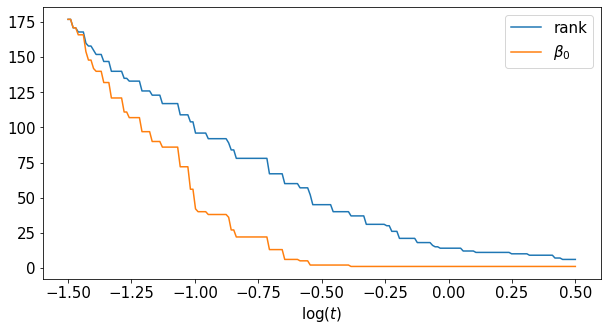

In [129]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times,rank, label = 'rank')
ax.plot(msf.log_times,beta_0[:-1], label = r'$\beta_0$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()